In [10]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

# Own settings
from settings import *
workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

## load TOOCAN
# from load_TOOCAN_DYAMOND_modif import load_TOOCAN_DYAMOND
from load_TOOCAN_DYAMOND_modif_BF import load_TOOCAN_DYAMOND

## current script object
thismodule = sys.modules[__name__]


Own modules available: ['conditionalstats', 'plot2D', 'plotCondPDFs', 'plot1D', 'conditionalstats_chunked']
Own modules available: ['fcns_load_DYAMOND_SAM', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'casestudy']


In [4]:
# Relation table
df = pd.read_csv(os.path.join(DIR_DATA,'relation_2_table_UTC_dyamond_segmentation.csv'))
df.sort_values(by='UTC',ignore_index=True,inplace=True)

# Define regions

In [5]:
# choose DYAMOND file

# an arbitrary time step
i_t = 900

root_DYAMOND = df.iloc[i_t]['path_dyamond']
# root_DYAMOND = 'DYAMOND_9216x4608x74_7.5s_4km_4608_0000460800.%s.2D.nc'
file_PW_DYAMOND = root_DYAMOND+'.PW.2D.nc'

In [6]:
# Load DYAMOND data
PW_DYAMOND = xr.open_dataarray(os.path.join(DIR_DYAMOND,file_PW_DYAMOND))

In [16]:
# define boxes (xmin,xmax,ymin,ymax)
box_1 = [310,340,0,20] # Atlantic ITCZ
box_2 = [205,250,0,20] # Eastern Pacific ITCZ
box_3 = [130,165,0,20] # Pacific Warm Pool
box_4 = [-20,35,0,20] # Central Africa

/home/bfildier/.conda/envs/pyLMD/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/bfildier/.conda/envs/pyLMD/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


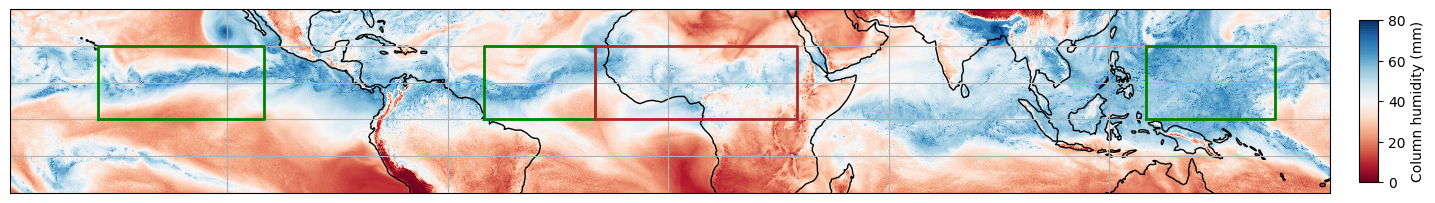

In [11]:
# Show boxes

cmap = plt.cm.RdBu
# cmap_mcs = plt.cm.get_cmap('rainbow', 10)
cmap_mcs = plt.cm.get_cmap('Accent', 10)
clim = (0,80)
lon_lim = (181,180)
lat_lim = (-20,30)
slice_lat = slice(*lat_lim)
proj = ccrs.PlateCarree(central_longitude=0)

# compute figuse size
dlon = np.diff(lon_lim)[0] % 360
dlat = np.diff(lat_lim)[0]
Lx_fig = 15
Lx_cbar = 1.5
Ly_title = 1
Ly_fig = (Lx_fig-Lx_cbar)/dlon*dlat + Ly_title

# Figure
fig = plt.figure(figsize=(Lx_fig,Ly_fig))
ax = plt.axes(projection=proj)

for slice_lon in slice(lon_lim[0],360),slice(0,lon_lim[1]):

    lat_dyamond = PW_DYAMOND.lat.sel(lat=slice_lat)
    lon_dyamond = PW_DYAMOND.lon.sel(lon=slice_lon)

    lonarray_dyamond,latarray_dyamond = np.meshgrid(lon_dyamond,lat_dyamond)

    # Background
    Z = PW_DYAMOND.sel(lon=slice_lon,lat=slice_lat)[0]
    im = ax.pcolormesh(lonarray_dyamond,latarray_dyamond,Z,transform=ccrs.PlateCarree(),alpha=0.9,cmap=cmap)
    im.set_clim(*clim)

    # # empty background
    # im = ax.pcolormesh(lonarray_dyamond,latarray_dyamond,np.full(lonarray_dyamond.shape,np.nan),transform=proj,alpha=0.9,cmap=cmap)
    
ax.set_extent([lon_lim[0]-360,lon_lim[1], *lat_lim],crs=proj)
ax.coastlines('110m')
ax.gridlines()
# ax.set_title('Example snapshot of SAM DYAMOND with TOOCAN objects')

# Draw rectangles
# ax.add_patch(Rectangle(*box_1),transform=ccrs.PlateCarree())
for box in box_1,box_2,box_3:
    ax.plot([box[0],box[0],box[1],box[1],box[0]], [box[2],box[3],box[3],box[2],box[2]],
             color='green', linewidth=2, marker='',
             transform=proj)
    
for box in box_4,:
    ax.plot([box[0],box[0],box[1],box[1],box[0]], [box[2],box[3],box[3],box[2],box[2]],
             color='brown', linewidth=2, marker='',
             transform=proj)

# colorbar
x,y,w,h = ax.get_position().bounds
dx = w/60
cax = plt.axes([x+w+1.5*dx,y,dx,h])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Column humidity (mm)')

# remove margins ?
fig.subplots_adjust(left=0.02)#, bottom=0.5, right=2, top=1, wspace=None, hspace=None)

# plt.savefig(os.path.join(DIR_FIG,'example_SAM_DYAMOND_PW_TOOCAN.png'),dpi=140)#,bbox_inches='tight')

plt.show()

# Define region name

In [12]:
box_4

[-20, 35, 0, 20]

In [13]:
def regionNameFromCoord(box):
    
    for coord,coordname in zip(box,['lonmin','lonmax','latmin','latmax']):
        
        if coord < 0 : 

            if re.compile('lon.*').match(coordname): setattr(thismodule,coordname,"%sW"%abs(coord))
            if re.compile('lat.*').match(coordname): setattr(thismodule,coordname,"%sS"%abs(coord))
            
        else:
            
            if re.compile('lon.*').match(coordname): setattr(thismodule,coordname,"%sE"%coord)
            if re.compile('lat.*').match(coordname): setattr(thismodule,coordname,"%sN"%coord)
    
    name = "%s_%s_%s_%s"%(lonmin,lonmax,latmin,latmax)
    
    return name

def regionCoordsFromName(name):
    
    # split into strings
    coord_str = name.split('_')
    # get absolute value
    coord_abs = [int(coord_str[i][:-1]) for i in range(len(coord_str))]
    # get direction
    coord_dir = [coord_str[i][-1:] for i in range(len(coord_str))]
    # adjust sign
    coord = [(-1)**(coord_dir[i] in ['S','W'])*coord_abs[i] for i in range(len(coord_str))]
    
    return coord
    

In [17]:
for i_b in range(1,5):
    box = getattr(thismodule,"box_%d"%i_b)
    regname = regionNameFromCoord(box)
    coords = regionCoordsFromName(regname)
    print(box,regname,coords)

[310, 340, 0, 20] 310E_340E_0N_20N [310, 340, 0, 20]
[205, 250, 0, 20] 205E_250E_0N_20N [205, 250, 0, 20]
[130, 165, 0, 20] 130E_165E_0N_20N [130, 165, 0, 20]
[-20, 35, 0, 20] 20W_35E_0N_20N [-20, 35, 0, 20]


# Make a relation table per region

In [14]:
df

,Unnamed: 0,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,img_seg_path,str_code,Unnamed: 0.1,Unnamed: 0.1.1,year,month,day,hour,minute,path_dyamond,UTC
0,476,476.0,476.0,476.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-1-30,2.0,2.0,2016.0,8.0,1.0,1.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000000720,17014.03
1,443,443.0,443.0,443.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-2-0,3.0,3.0,2016.0,8.0,1.0,2.0,0.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000000960,17014.04
2,468,468.0,468.0,468.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-2-30,4.0,4.0,2016.0,8.0,1.0,2.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000001200,17014.05
3,432,432.0,432.0,432.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-3-0,5.0,5.0,2016.0,8.0,1.0,3.0,0.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000001440,17014.06
4,437,437.0,437.0,437.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-8-1-3-30,6.0,6.0,2016.0,8.0,1.0,3.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000001680,17014.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,1295,1295.0,1295.0,1295.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-9-9-22-30,1916.0,1916.0,2016.0,9.0,9.0,22.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000460080,17053.45
1915,1315,1315.0,1315.0,1315.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-9-9-23-0,1917.0,1917.0,2016.0,9.0,9.0,23.0,0.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000460320,17053.46
1916,1313,1313.0,1313.0,1313.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-9-9-23-30,1918.0,1918.0,2016.0,9.0,9.0,23.0,30.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000460560,17053.47
1917,1304,1304.0,1304.0,1304.0,data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...,2016-9-10-0-0,1919.0,1919.0,2016.0,9.0,10.0,0.0,0.0,DYAMOND_9216x4608x74_7.5s_4km_4608_0000460800,17053.48


In [63]:
# choose box
box = box_1
# pattern for regional data path
REG_PATH_pattern = '/data/bfildier/DYAMOND_REGIONS/%s/SAM/TOOCAN_SEG'
region_name = regionNameFromCoord(box)
REG_PATH = REG_PATH_pattern%region_name
# define seg_path column
img_seg_path_reg = [None if np.array(df.img_seg_path)[i_df] is np.nan else os.path.join(REG_PATH,os.path.basename(df.img_seg_path[i_df])) for i_df in range(len(df))]


In [61]:
np.where([np.array(df.img_seg_path)[i] is np.nan for i in range(len(df))])

(array([1918]),)

In [34]:
! ls /data/bfildier/DYAMOND_REGIONS/130E_165E_0N_20N/SAM/TOOCAN_SEG

ImageSegTOOCAN_20160801-03.nc  ImageSegTOOCAN_20160821-03.nc
ImageSegTOOCAN_20160801-04.nc  ImageSegTOOCAN_20160821-04.nc
ImageSegTOOCAN_20160801-05.nc  ImageSegTOOCAN_20160821-05.nc
ImageSegTOOCAN_20160801-06.nc  ImageSegTOOCAN_20160821-06.nc
ImageSegTOOCAN_20160801-07.nc  ImageSegTOOCAN_20160821-07.nc
ImageSegTOOCAN_20160801-08.nc  ImageSegTOOCAN_20160821-08.nc
ImageSegTOOCAN_20160801-09.nc  ImageSegTOOCAN_20160821-09.nc
ImageSegTOOCAN_20160801-10.nc  ImageSegTOOCAN_20160821-10.nc
ImageSegTOOCAN_20160801-11.nc  ImageSegTOOCAN_20160821-11.nc
ImageSegTOOCAN_20160801-12.nc  ImageSegTOOCAN_20160821-12.nc
ImageSegTOOCAN_20160801-13.nc  ImageSegTOOCAN_20160821-13.nc
ImageSegTOOCAN_20160801-14.nc  ImageSegTOOCAN_20160821-14.nc
ImageSegTOOCAN_20160801-15.nc  ImageSegTOOCAN_20160821-15.nc
ImageSegTOOCAN_20160801-16.nc  ImageSegTOOCAN_20160821-16.nc
ImageSegTOOCAN_20160801-17.nc  ImageSegTOOCAN_20160821-17.nc
ImageSegTOOCAN_20160801-18.nc  ImageSegTOOCAN_20160821-18.nc
ImageSegTOOCAN_20160801-